In [3]:
import numpy as np
from  matplotlib import pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})
#plt.rcParams["font.weight"] = 'light'
#plt.rcParams["axes.labelweight"] = 'light'
#plt.rcParams["font.family"] = ['Times New Roman']
from scipy.ndimage import gaussian_filter

import cycler

import histlite as hl

import sys
sys.path.append('/g/g20/lenardo1/software/')
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration

import os
from datetime import datetime
import time

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
path_to_binary = '/p/lustre1/lenardo1/stanford_teststand/RAW_DATA_TEST/'


input_file = 'SIS3316Raw_20200916051219_SiPMs_longTPC_sbias32_scope_trig13_36mV_cath_6kV_1.bin'

In [5]:

with open(path_to_binary+input_file,'rb') as infile:
    header = []
    for i in range(200):
        header.append(infile.read(4))

In [6]:
print(header[0].hex())

01001633


In [7]:
import struct
i=0
for word in header:
    print('{}\t{}'.format(i,hex(struct.unpack("<I",word)[0])))
    i+=1

0	0x33160001
1	0x0
2	0xe513
3	0x0
4	0x0
5	0x0
6	0x0
7	0x0
8	0x0
9	0x0
10	0x0
11	0x0
12	0x0
13	0x0
14	0x0
15	0x0
16	0x0
17	0x0
18	0x0
19	0x0
20	0x0
21	0x0
22	0x0
23	0x0
24	0x0
25	0x0
26	0x0
27	0x0
28	0x0
29	0x0
30	0x0
31	0x0
32	0x0
33	0x0
34	0x0
35	0x0
36	0x0
37	0x0
38	0x0
39	0x0
40	0x0
41	0x0
42	0x0
43	0x0
44	0x0
45	0x0
46	0x0
47	0x0
48	0x0
49	0x0
50	0x0
51	0x0
52	0x0
53	0x0
54	0x0
55	0x0
56	0x0
57	0x0
58	0x0
59	0x0
60	0x0
61	0x0
62	0x0
63	0x0
64	0x0
65	0x0
66	0x0
67	0x0
68	0x0
69	0x0
70	0x0
71	0x0
72	0x0
73	0x0
74	0x0
75	0x0
76	0x0
77	0x0
78	0x0
79	0x0
80	0x0
81	0x0
82	0x0
83	0x0
84	0x0
85	0x0
86	0x0
87	0x0
88	0x0
89	0x0
90	0x0
91	0x0
92	0x0
93	0x0
94	0x0
95	0x0
96	0x0
97	0x0
98	0x0
99	0x0
100	0xabbaabba
101	0xabbaabba
102	0xabbaabba
103	0xabbaabba
104	0xabbaabba
105	0xabbaabba
106	0xabbaabba
107	0xabbaabba
108	0xabbaabba
109	0xabbaabba
110	0x0
111	0x0
112	0x0
113	0x0
114	0x93
115	0x0
116	0x93
117	0x0
118	0x0
119	0xb3e8f
120	0x5
121	0x4e14
122	0x26039581
123	0x227731
124	0x5bde2
125	0

In [8]:
word = struct.unpack("<I",header[120])[0] #int(hex(struct.unpack("<I",header[120])[0]),16)
print(word)
print(bin((word<<4)&0xf0))
i=0
for bit in bin(word):
    print('{}\t{}'.format(i,bit))
    i+=1
#print(len(word))

5
0b1010000
0	0
1	b
2	1
3	0
4	1


In [20]:
def read_file( filename, max_num_of_spills=1 ):
    
    start_time = time.time()
    
    total_words_read = 0
    spills_list = []
    run_header = []
    spill_counter = 0
    
    
    with open(filename,'rb') as infile:
        
        # Read in the runhdr (one per file)
        for i in range(100):
            run_header.append(hex(struct.unpack("<I",infile.read(4))[0]))

        first_word_of_spillhdr = hex(struct.unpack("<I",infile.read(4))[0])
        
        while True:
            #print('\n')
            spill_time = (time.time() - start_time)/60.
            print('Reading spill {} at {:4.4} min'.format(spill_counter,spill_time))
            #print('First word of spillhdr: {}'.format(first_word_of_spillhdr))
            
            # this allows us to check if we're actually on a new spill or not
            if first_word_of_spillhdr == '0xabbaabba':
                spill_dict, words_read, last_word_read = \
                        read_spill( infile, first_word_of_spillhdr )
            elif first_word_of_spillhdr == '0xe0f0e0f':
                break
            spills_list.append(spill_dict)
            total_words_read += words_read
            spill_counter += 1
            first_word_of_spillhdr = last_word_read
            
            if (spill_counter > max_num_of_spills) and\
                (max_num_of_spills >= 0):
                break
                
    end_time = time.time()
    print('\nTime elapsed: {:4.4} min'.format((end_time-start_time)/60.))
    
    return run_header, spills_list, words_read, spill_counter
        
    
    
            
        
def read_spill( infile, first_entry_of_spillhdr ):
    
    debug=False
    
    spill_dict = {}
    spill_words_read = 0
    
    spill_header = []
    spill_header.append(first_entry_of_spillhdr)
    for i in range(9):
        spill_header.append(hex(struct.unpack("<I",infile.read(4))[0]))
    spill_dict['spillhdr'] = spill_header
    
    if spill_header[0] == '0xe0f0e0f':
        return spill_dict, 0
    
    data_list = []
    previous_card_id = 9999999
    
    while True:
        data_dict = {}
        hdrid = 0
        
        # Grab the first word, which should be either a hdrid or a phdrid
        hdrid_temp = struct.unpack("<I",infile.read(4))[0]
        
        # Break the loop if we've reached the next spill
        if hex(hdrid_temp) == '0xabbaabba' or \
            hex(hdrid_temp) == '0xe0f0e0f': 
            last_word_read = hex(hdrid_temp)
            break
        
        this_card_id = (0xff000000&hdrid_temp) >> 24
        if debug:
            print('hdrid_temp: {}'.format(hex(hdrid_temp)))
            print('Card ID: {}'.format(this_card_id))
        data_dict['card'] = this_card_id

        if (this_card_id != previous_card_id) and (hdrid_temp&0xff0000 == 0):
            # If we've switched to a new card and are on channel 0, there should
            # be a phdrid; two 32-bit words long.
            
            #print('\nREADING NEXT CARD')
            phdrid = []
            phdrid.append(hdrid_temp)
            phdrid.append(struct.unpack("<I",infile.read(4))[0])
            data_dict['phdrid'] = phdrid
            if debug:
                print('phdrid:')
                for val in phdrid:
                   print('\t{}'.format(hex(val)))
                    
            hdrid = struct.unpack("<I",infile.read(4))[0]
            previous_card_id = this_card_id
        else:
            # if not, then the hdrid_temp read in above must be the hdrid for 
            # the individual channel
            hdrid = hdrid_temp
            
        data_dict['hdrid'] = hex(hdrid)
        if debug: print('hdrid: {}'.format(data_dict['hdrid']))
            
        channel_id = ( (0xc00000&hdrid)>>22 ) * 4 + ( (0x300000&hdrid)>>20 )
        if debug: print('channelid: {}'.format(channel_id))
            
        data_dict['chan'] = channel_id
            
        channel_dict, words_read = read_channel( infile )
        data_dict['data'] = channel_dict
        
        spill_words_read += words_read
        data_list.append(data_dict)
        
    
    spill_dict['spill'] = data_list
        
    return spill_dict, spill_words_read, last_word_read




    
def read_channel( infile ):
    # Assumes we've already read in the hdrid
    trigger_stat_spill = []
    
    channel_dict = {}
    
    # Trigger stat. counters are defined in Chapter 4.9 of Struck manual
    # 0 - Internal trigger counter
    # 1 - Hit trigger counter
    # 2 - Dead time trigger counter
    # 3 - Pileup trigger counter
    # 4 - Veto trigger counter
    # 5 - High-Energy trigger counter
    for i in range(6):
        trigger_stat_spill.append(hex(struct.unpack("<I",infile.read(4))[0]))
    channel_dict['trigger_stat_spill'] = trigger_stat_spill
        
    # Data_buffer_size stores the number of words needed to read all the 
    # events for a channel in the current spill. Its size should be an integer
    # multiple of:
    # (# of header words, defined by format bits) + (# of samples/waveform)/2. 
    data_buffer_size = struct.unpack("<I",infile.read(4))[0]
    channel_dict['data_buffer_size'] = data_buffer_size
    
    total_words_read = 0
    num_loops = 0
    events = []
    
    while total_words_read < data_buffer_size:
        #if num_loops%10==0: print('On loop {}'.format(num_loops))
        words_read, event = read_event(infile)
        total_words_read += words_read
        events.append(event)
        num_loops += 1
        
    channel_dict['events'] = events
    
    return channel_dict, total_words_read
    
    
            
        
def read_event( infile ):
    # The "event" structure is defined in Chapter 4.6 of the Struck manual. 
    # This starts with the Timestamp and ends with ADC raw data (we do not use
    # the MAW test data at this time)
    
    event = {}
    bytes_read = 0
    
    word = struct.unpack("<I",infile.read(4))[0]
    bytes_read += 4
    
    event['format_bits'] = 0xf&word
    event['channel_id'] = 0xff0&word
    event['timestamp_47_to_32'] = 0xffff0000&word
    
    word = struct.unpack("<I",infile.read(4))[0]
    bytes_read += 4
    event['timestamp_full'] = word | (event['timestamp_47_to_32']<<32)
    
    if bin(event['format_bits'])[-1] == '1':
        
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['peakhigh_val'] = 0x0000ffff & word
        event['index_peakhigh_val'] = 0xffff0000 & word
        
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['information'] = 0xff00000 & word
        event['acc_g1'] = 0x00ffffff & word
        
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['acc_g2'] = 0x00ffffff & word

        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['acc_g3'] = 0x00ffffff & word
        
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['acc_g4'] = 0x00ffffff & word
        
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['acc_g5'] = 0x00ffffff & word
        
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['acc_g6'] = 0x00ffffff & word
        
    if bin(event['format_bits']>>1)[-1] == '1':
        
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['acc_g7'] = 0x00ffffff & word

        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['acc_g8'] = 0x00ffffff & word
    
    if bin(event['format_bits']>>2)[-1] == '1':

        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['maw_max_val'] = 0x00ffffff & word
    
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['maw_val_pre_trig'] = 0x00ffffff & word

        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['maw_val_post_trig'] = 0x00ffffff & word
        
    if bin(event['format_bits']>>3)[-1] == '1':
        
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['start_energy_val'] = 0x00ffffff & word
    
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['max_energy_val'] = 0x00ffffff & word
        
        
    word = struct.unpack("<I",infile.read(4))[0]
    
    bytes_read += 4
    event['num_raw_samples'] = 0x03ffffff & word
    event['maw_test_flag'] = 0x08000000 & word
    event['status_flag'] = 0x04000000 & word
    
    event['samples'] = []
    for i in range(event['num_raw_samples']):
        word = struct.unpack("<I",infile.read(4))[0]
        bytes_read += 4
        event['samples'].append(word&0x0000ffff)
        event['samples'].append((word>>16)&0x0000ffff)
    
    if event['maw_test_flag'] == 1:
    
        for i in range(event['num_raw_samples']):
            word = struct.unpack("<I",infile.read(4))[0]
            bytes_read += 4
            event['maw_test_data'].append(word&0x0000ffff)
            event['maw_test_data'].append((word>>16)&0x0000ffff)
        
    words_read = bytes_read / 4
    return words_read, event
        
    
            
        
            
        
            
        
            
        

In [21]:
run_header, spills_list, words_read, spill_counter = read_file(path_to_binary+input_file, 3)



Reading spill 0 at 4.236e-05 min
Reading spill 1 at 0.4183 min
Reading spill 2 at 0.8412 min
Reading spill 3 at 1.26 min

Time elapsed: 1.689 min


In [38]:
print(run_header)



['0x33160001', '0x0', '0xe513', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0']


In [44]:
first_spill = spills_list[0]
print(first_spill['spillhdr'])

channel_data = first_spill['spill'][20]
print('Card: {}'.format(channel_data['card']))
print('Channel: {}'.format(channel_data['chan']))
print('Channel: {}'.format(channel_data['data']['trigger_stat_spill']))

['0xabbaabba', '0xabbaabba', '0xabbaabba', '0xabbaabba', '0xabbaabba', '0xabbaabba', '0xabbaabba', '0xabbaabba', '0xabbaabba', '0xabbaabba']
Card: 1
Channel: 4
Channel: ['0x0', '0x93', '0x0', '0x93', '0x0', '0x0']


In [40]:
print(channel_data['data']['events'][0])

{'format_bits': 5, 'channel_id': 320, 'timestamp_47_to_32': 0, 'timestamp_full': 19988, 'peakhigh_val': 28003, 'index_peakhigh_val': 395640832, 'information': 1048576, 'acc_g1': 1669139, 'acc_g2': 278327, 'acc_g3': 278327, 'acc_g4': 278327, 'acc_g5': 278327, 'acc_g6': 278327, 'maw_max_val': 61707, 'maw_val_pre_trig': 61707, 'maw_val_post_trig': 0, 'num_raw_samples': 5000, 'maw_test_flag': 0, 'status_flag': 0, 'samples': [27827, 27839, 27827, 27807, 27801, 27715, 27761, 27801, 27789, 27844, 27838, 27839, 27775, 27821, 27802, 27851, 27810, 27833, 27828, 27861, 27868, 27865, 27836, 27801, 27814, 27814, 27797, 27797, 27815, 27797, 27788, 27810, 27858, 27851, 27854, 27808, 27839, 27824, 27798, 27807, 27863, 27836, 27842, 27807, 27825, 27811, 27782, 27821, 27804, 27816, 27819, 27775, 27852, 27855, 27828, 27817, 27876, 27803, 27752, 27845, 27897, 27847, 27834, 27843, 27781, 27812, 27817, 27796, 27840, 27856, 27828, 27830, 27850, 27848, 27841, 27862, 27834, 27841, 27829, 27828, 27847, 27832, 2

2494558


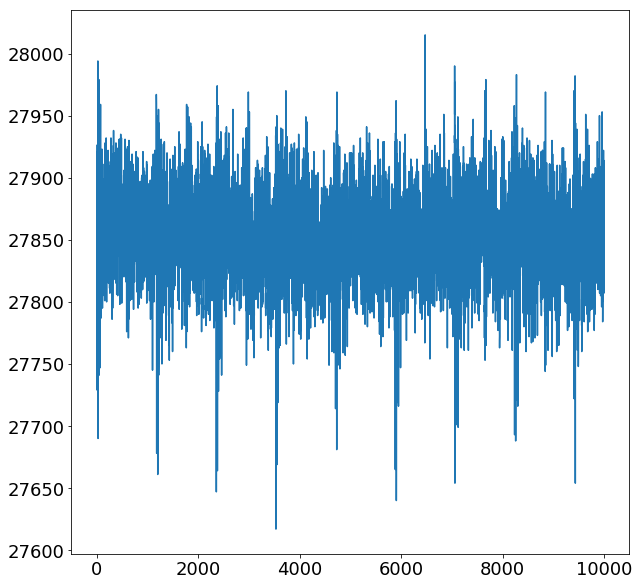

In [42]:
evt_idx = 3

print(channel_data['data']['events'][evt_idx]['timestamp_full'])
plt.plot(channel_data['data']['events'][evt_idx]['samples'])